# Practical session: Convolutional Neural Networks (CNN) 

Convolutional Neural Networks (CNNs) are a type of deep learning model particularly effective for processing and analyzing visual data like images and videos. CNNs use a special structure that allows them to automatically and adaptively learn spatial hierarchies of features. This is done through layers like convolutional layers, pooling layers, and fully connected layers. Convolutional layers apply filters to the input, capturing essential patterns such as edges, textures, and shapes. This makes CNNs especially powerful for tasks like image classification, object detection, and facial recognition.

<img width="600" alt="image" src="https://saturncloud.io/images/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way.webp">

## Overview

This practical session focuses on using Convolutional Neural Networks (CNNs) to classify images into ten distinct categories, utilizing the `Fashion-MNIST` dataset.

### Key Objectives:
- **Grasping the Fundamentals of CNNs:** Gain a solid understanding of how CNNs function, including their role in image classification tasks.
- **Exploring Layer Functionality:** Learn how different layers in a CNN contribute to feature extraction and classification, transforming raw image data into meaningful predictions.
- **Constructing a Basic CNN Model:** Build a simple yet effective CNN model tailored to the Fashion-MNIST dataset, applying best practices in model architecture.
- **Training the CNN Model:** Train the CNN model, understanding the role of epochs, batch sizes, and the learning process involved in optimizing the model’s performance.
- **Evaluating Model Performance:** Assess the accuracy and effectiveness of your CNN model using appropriate evaluation metrics and visualization techniques.
- **Tuning CNN Hyperparameters:** Experiment with and manipulate key hyperparameters to improve model performance and gain deeper insights into CNN optimization.


## Dataset

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

<img width="400" alt="image" src="https://i.imgur.com/BxGMWW4.png">


You can use direct links to download the dataset or use the folder `/data`.

- Original source: https://github.com/zalandoresearch/fashion-mnist

Folder `/data` includes a column based format of this dataset: 
- `fashion-mnist_train.csv`
- `fashion-mnist_test.csv`

A quick description of these files: 

- Each image measures 28 by 28 pixels, totaling 784 pixels.
- Every pixel has a corresponding value that reflects its brightness, with higher values indicating a darker shade. These values range from 0 to 255.
- Both the training and test datasets contain 785 columns.
- The first column holds the class labels, representing the type of clothing item.
- The remaining 784 columns (1-785) store the pixel values for the corresponding image.


### Labels
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |



## Data loading

In [1]:
## Importing Libraries 

# Base libraries
import numpy as np
import pandas as pd
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualisation 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

print("tensorflow v."+tf.__version__)

## Default options and global variables
# Set number of decimal points to float type
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option('display.precision', 2)
SEED = 2024
N_CLASSES = 10
keras.utils.set_random_seed(SEED)


tensorflow v.2.14.0


In [3]:
# Set the data path 
DATA_PATH="../data/Fashion-MNIST/"

# Data loading
df_train = pd.read_csv(DATA_PATH + "fashion-mnist_train.csv.zip")
df_test = pd.read_csv(DATA_PATH + "fashion-mnist_test.csv.zip")

# Data dimension 
print("Train set:",df_train.shape[0],"rows,",  df_train.shape[1], "columns")
print("Test set :",df_test.shape[0],"rows,",  df_test.shape[1], "columns")


Train set: 60000 rows, 785 columns
Test set : 10000 rows, 785 columns


### Quick exploration

In [4]:
# Quick exploration 
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Target variable

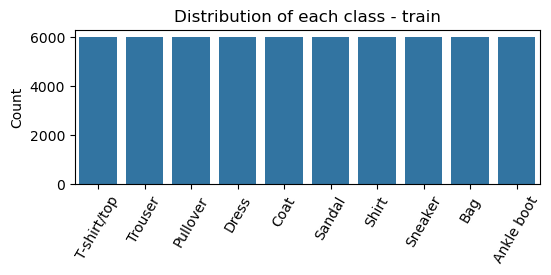

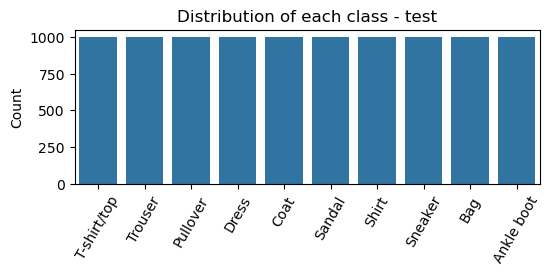

In [5]:
# Labels  
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_label_distributions (data, info):
    plt.figure(figsize=(6,2))
    unique_labels, data_counts = np.unique(data, return_counts=True)
    sns.barplot(x=unique_labels, y=data_counts)
    # labeling the plot
    plt.xticks( unique_labels, labels, rotation=60)
    plt.ylabel('Count')
    plt.title('Distribution of each class - ' + info)

plot_label_distributions(df_train['label'], "train")
plot_label_distributions(df_test['label'], "test")


In [6]:
## Subsampling ~ 50% 
df_train_sample = df_train.sample(n=30000, random_state=SEED)

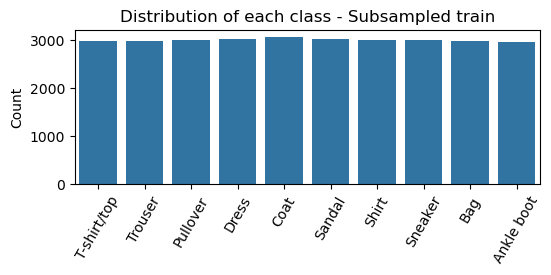

In [7]:
plot_label_distributions(df_train_sample['label'], "Subsampled train")

## Modelling 

We use [tf.keras](https://www.tensorflow.org/guide/keras) to build and train models. Keras is the high-level API of the TensorFlow platform. It provides an approachable, highly-productive interface for solving machine learning (ML) problems, with a focus on modern deep learning.

The `tf.keras.Model` class features built-in training and evaluation methods:

- `tf.keras.Model.fit`: Trains the model for a fixed number of epochs.
- `tf.keras.Model.predict`: Generates output predictions for the input samples.
- `tf.keras.Model.evaluate`: Returns the loss and metrics values for the model; configured via the `tf.keras.Model.compile` method.

### Data preparation

In [8]:
## Dataset preparation 

# Variables for modelling
#x_train = df_train.drop(columns=['label']).values
#y_train = df_train[['label']].values
x_train = df_train_sample.drop(columns=['label']).values
y_train = df_train_sample[['label']].values
x_test = df_test.drop(columns=['label']).values
y_test = df_test[['label']].values

# Reshaping the colums 784 (one dimensional format) to 28x28 (two dimensional array)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)

# Alternative, you can fetch the "Fashion MNIST" data from Keras. 
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Use OneHotEncoder to encode target column ~ binary representation 
y_train = to_categorical(y_train, num_classes=N_CLASSES)
y_test  = to_categorical(y_test, num_classes=N_CLASSES)


In [9]:
print("Shape of Training Image Data: " + str(x_train.shape))
print("Shape of Training Class Data: " + str(y_train.shape))
print("Shape of Test Image Data: " + str(x_test.shape))
print("Shape of Test Class Data: " + str(y_test.shape))

Shape of Training Image Data: (30000, 28, 28, 1)
Shape of Training Class Data: (30000, 10)
Shape of Test Image Data: (10000, 28, 28, 1)
Shape of Test Class Data: (10000, 10)


In [10]:
np.argmax( y_train[2])
y_train[2]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

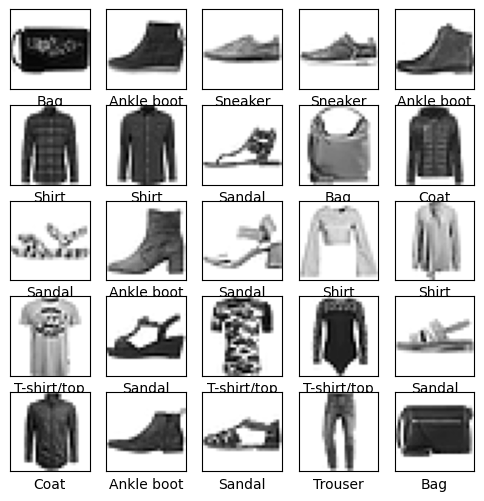

In [11]:
# plot few images 
plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel( labels[np.argmax(y_train[i])])
plt.show()

### Model definition

In [12]:
## Model definition
model = Sequential() # The sequential model is a linear stack of layers. Add layers by using the `add` method 
# Layers 
model.add( Flatten())
model.add( Dense(128, activation='tanh'))
model.add( Dense(N_CLASSES, activation='softmax'))

2024-09-18 02:06:07.061586: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-18 02:06:07.061625: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-18 02:06:07.061634: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-18 02:06:07.061920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-18 02:06:07.062605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Model compilation

Before the model is ready for training, a few additional settings need to be configured during the model's compile step:

- **Loss Function**: Measures the model's accuracy during training. The goal is to minimize this loss, guiding the model to improve its predictions.
- **Optimizer**: Updates the model's parameters based on the data and loss. This helps the model learn from its errors.
- **Metrics**: Track the model's performance during training and testing.


In [13]:
## Model compliation 
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.1)
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer= optimizer,
    metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


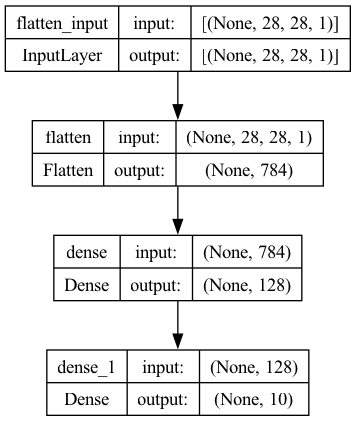

In [14]:
## Model vis
model.build(input_shape=(None, 28,28,1))
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

### Model fitting


In [15]:
BATCH=64
EPOCHS=12

history_model = model.fit(x_train, y_train,
                  batch_size=BATCH,
                  epochs=EPOCHS,
                  verbose=1)

Epoch 1/12
  1/469 [..............................] - ETA: 2:04 - loss: 3.3248 - accuracy: 0.0469

2024-09-18 02:07:00.565989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 4s 8ms/step - loss: 1.8604 - accuracy: 0.2705
Epoch 2/12
469/469 [==============================] - 4s 8ms/step - loss: 1.8617 - accuracy: 0.2442
Epoch 3/12
469/469 [==============================] - 4s 8ms/step - loss: 1.7892 - accuracy: 0.2874
Epoch 4/12
469/469 [==============================] - 4s 8ms/step - loss: 1.8303 - accuracy: 0.2603
Epoch 5/12
469/469 [==============================] - 4s 9ms/step - loss: 1.9227 - accuracy: 0.2102
Epoch 6/12
469/469 [==============================] - 4s 8ms/step - loss: 1.9135 - accuracy: 0.2010
Epoch 7/12
469/469 [==============================] - 4s 9ms/step - loss: 1.9102 - accuracy: 0.2005
Epoch 8/12
469/469 [==============================] - 4s 8ms/step - loss: 2.1896 - accuracy: 0.1824
Epoch 9/12
469/469 [==============================] - 4s 9ms/step - loss: 2.0348 - accuracy: 0.2103
Epoch 10/12
469/469 [==============================] - 4s 8ms/step - loss: 2.1030 - accuracy: 0.1864
Epoch 11/1

### Model evaluation 

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.016242027282715
Test accuracy: 0.20389999449253082


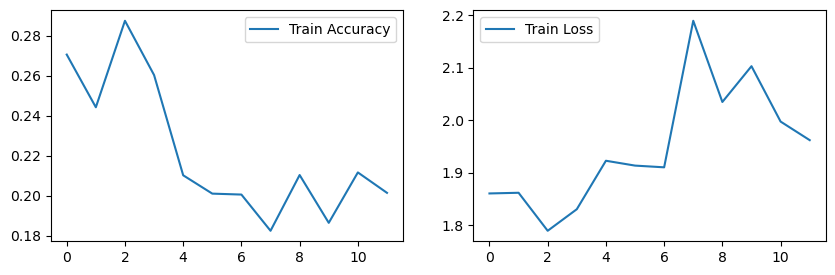

In [18]:
from matplotlib.ticker import MaxNLocator
#%matplotlib inline

def plot_model_history (history_model):
    fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    # loss
    ax1.plot(history_model.history['loss'], label='Train Loss')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.legend()
    # accuracy
    ax2.plot(history_model.history['accuracy'], label='Train Accuracy')
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.legend()

plot_model_history(history_model)

### Model predictions




In [19]:
predictions = model.predict(x_test)


313/313 [==============================] - 1s 1ms/step


In [20]:
# A prediction is an array of the confidence values that correspont to each category (label)
predictions[6]


array([0.00892536, 0.00119143, 0.18220668, 0.01234986, 0.08166344,
       0.11890014, 0.03334073, 0.28044647, 0.12015601, 0.16081989],
      dtype=float32)

In [21]:
# Label with the highest confidence
np.argmax(predictions[6])

7

In [22]:
## Helper functions
def plot_prediction(i, predictions, true_label, img):
  predictions, true_label, img = predictions[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions),
                                labels[true_label]),
                                color=color)

def plot_prediction_confidence(i, predictions, true_label):
  predictions, true_label = predictions[i], true_label[i]
  plt.grid(False)
  #plt.xticks()
  plt.xticks( range(N_CLASSES), labels, rotation=80)
  plt.yticks([])
  thisplot = plt.bar(range(N_CLASSES), predictions, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

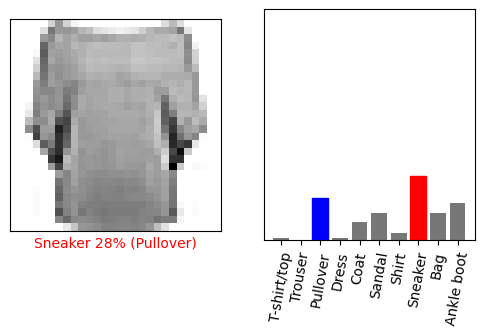

In [23]:
i = 5
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_prediction(i, predictions, df_test['label'], x_test)
plt.subplot(1,2,2)
plot_prediction_confidence(i, predictions,  df_test['label'])
plt.show()

### Model mistakes

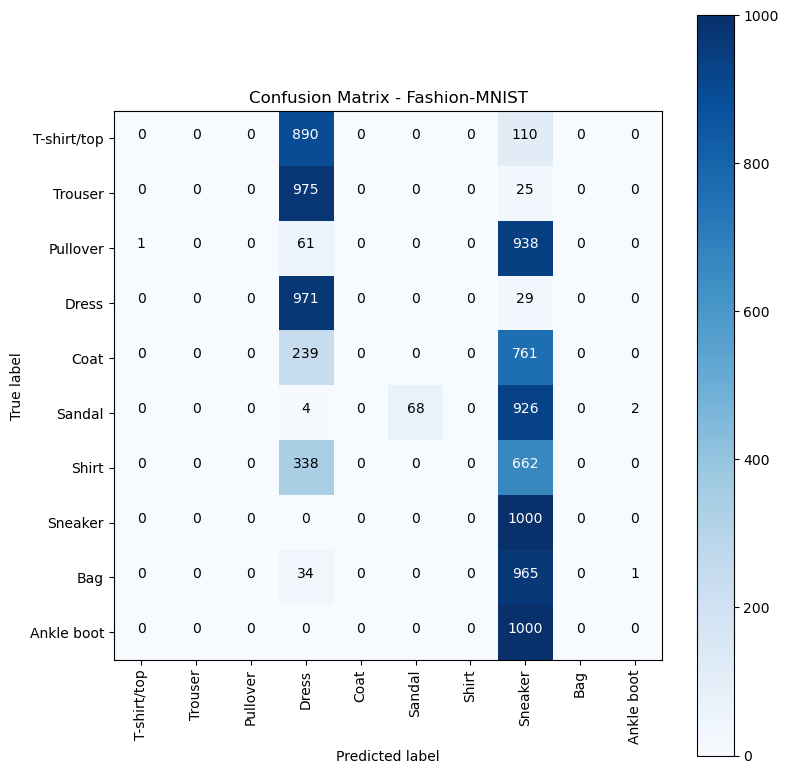

In [24]:
from sklearn.metrics import confusion_matrix
from itertools import product


##Create Multiclass Confusion Matrix
def plot_confusion_matrix(predictions, y_test):
    cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predictions,axis=1))

    plt.figure(figsize=(8,8))
    plt.imshow(cm,cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Fashion-MNIST')
    plt.colorbar()
    plt.xticks(range(N_CLASSES), labels, rotation=90)
    plt.yticks(range(N_CLASSES), labels)

    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(predictions,y_test)

## Model tunning


### model1 



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               692352    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693962 (2.65 MB)
Trainable params: 693962 (2.65 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

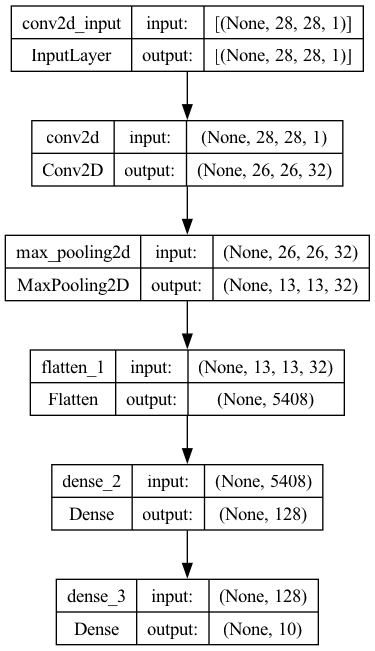

In [25]:
## Model architecture ~ layers 

# Adding layers to extract features 

model1 = Sequential() # The sequential model is a linear stack of layers. Add layers by using the `add` method 

# Feature extration 

model1.add( Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=(28, 28, 1)) ) # # 2D Convolutional layer with 32 filters (output)
model1.add( MaxPooling2D(pool_size=(2,2)) ) 

# Classification 
model1.add( Flatten())
model1.add( Dense(128, activation='tanh'))
model1.add( Dense(N_CLASSES, activation='softmax'))

## Model compliation 
model1.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=optimizer,
    metrics=['accuracy'])

## Model vis
model1.summary()
plot_model(model1, show_shapes=True, show_layer_names=True)

In [26]:
history_model1 = model1.fit(x_train, y_train,
                  batch_size=BATCH,
                  epochs=EPOCHS,
                  verbose=1)

Epoch 1/12
469/469 [==============================] - 5s 11ms/step - loss: 2.3038 - accuracy: 0.1467
Epoch 2/12
469/469 [==============================] - 5s 10ms/step - loss: 2.3875 - accuracy: 0.1183
Epoch 3/12
469/469 [==============================] - 5s 10ms/step - loss: 2.4567 - accuracy: 0.1017
Epoch 4/12
469/469 [==============================] - 5s 10ms/step - loss: 2.4637 - accuracy: 0.0984
Epoch 5/12
469/469 [==============================] - 5s 10ms/step - loss: 2.4532 - accuracy: 0.1012
Epoch 6/12
469/469 [==============================] - 5s 10ms/step - loss: 2.4669 - accuracy: 0.0969
Epoch 7/12
469/469 [==============================] - 5s 10ms/step - loss: 2.4536 - accuracy: 0.1006
Epoch 8/12
469/469 [==============================] - 5s 10ms/step - loss: 2.4653 - accuracy: 0.0986
Epoch 9/12
469/469 [==============================] - 5s 11ms/step - loss: 2.4562 - accuracy: 0.0987
Epoch 10/12
469/469 [==============================] - 5s 10ms/step - loss: 2.4530 - accura

Test loss: 2.5030579566955566
Test accuracy: 0.10019999742507935


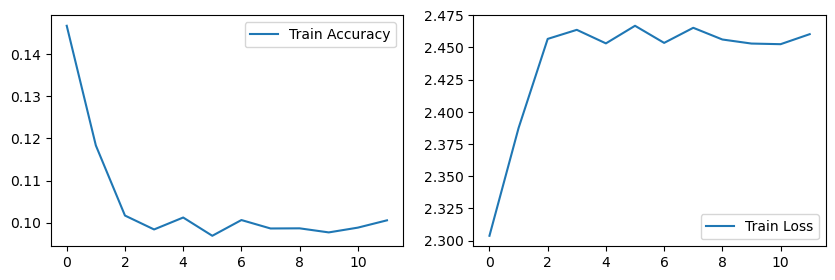

In [27]:
score = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_model_history(history_model1)

### model2

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

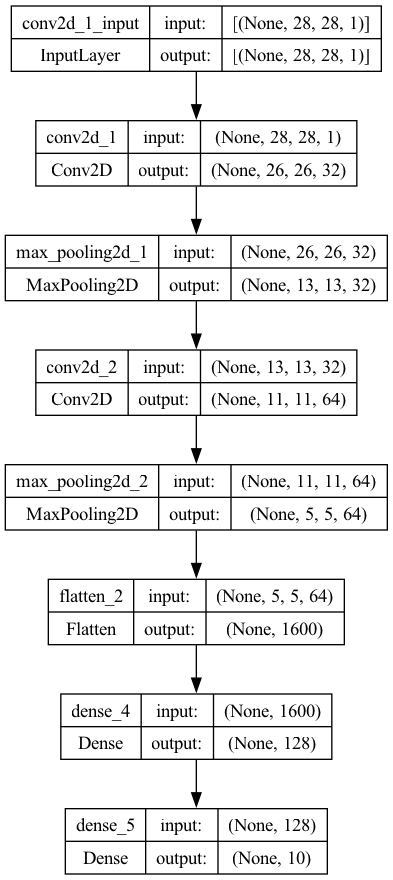

In [28]:
## Model architecture ~ layers 

# Adding layers to extract features 

model2 = Sequential() # The sequential model is a linear stack of layers. Add layers by using the `add` method 

# Feature extration 

model2.add( Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=(28, 28, 1)) ) # # 2D Convolutional layer with 32 filters (output)
model2.add( MaxPooling2D(pool_size=(2,2)) ) 
model2.add( Conv2D(64, kernel_size=(3,3),activation='relu') ) # # 2D Convolutional layer with 64 filters (output)
model2.add( MaxPooling2D(pool_size=(2,2)) ) 
#model2.add( Conv2D(128, kernel_size=(3,3),activation='relu') ) # # 2D Convolutional layer with 64 filters (output)
# Classification 
model2.add( Flatten())
model2.add( Dense(128, activation='relu'))
model2.add( Dense(N_CLASSES, activation='softmax'))

## Model compliation 
model2.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

## Model vis
model2.summary()
plot_model(model2, show_shapes=True, show_layer_names=True)

In [29]:
history_model2 = model2.fit(x_train, y_train,
                  batch_size=BATCH,
                  epochs=EPOCHS,
                  verbose=1)

Epoch 1/12
469/469 [==============================] - 6s 12ms/step - loss: 1.8296 - accuracy: 0.7441
Epoch 2/12
469/469 [==============================] - 6s 12ms/step - loss: 0.7513 - accuracy: 0.8143
Epoch 3/12
469/469 [==============================] - 5s 12ms/step - loss: 0.7213 - accuracy: 0.8337
Epoch 4/12
469/469 [==============================] - 6s 12ms/step - loss: 0.8082 - accuracy: 0.8431
Epoch 5/12
469/469 [==============================] - 6s 12ms/step - loss: 1.1182 - accuracy: 0.8435
Epoch 6/12
469/469 [==============================] - 6s 12ms/step - loss: 1.2430 - accuracy: 0.8550
Epoch 7/12
469/469 [==============================] - 5s 12ms/step - loss: 1.9571 - accuracy: 0.8479
Epoch 8/12
469/469 [==============================] - 6s 12ms/step - loss: 3.0422 - accuracy: 0.8517
Epoch 9/12
469/469 [==============================] - 6s 12ms/step - loss: 4.4474 - accuracy: 0.8565
Epoch 10/12
469/469 [==============================] - 5s 12ms/step - loss: 7.5935 - accura

Test loss: 19.50323486328125
Test accuracy: 0.8655999898910522


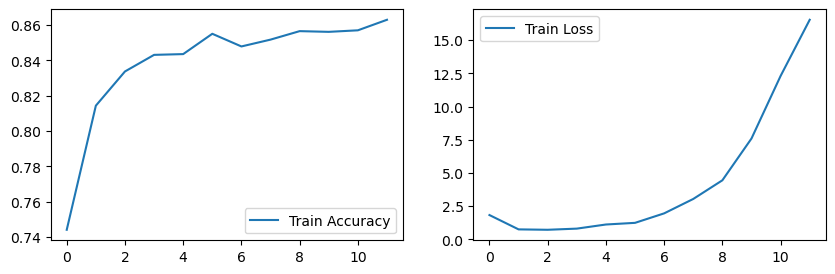

In [30]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_model_history(history_model2)

### model3

In [31]:
## Model architecture ~ layers 

# Adding layers to extract features 

model3 = Sequential() # The sequential model is a linear stack of layers. Add layers by using the `add` method 

# Feature extration 

model3.add( Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=(28, 28, 1)) ) # # 2D Convolutional layer with 32 filters (output)
model3.add( MaxPooling2D(pool_size=(2,2)) ) 
model3.add( Conv2D(64, kernel_size=(3,3),activation='relu') ) # # 2D Convolutional layer with 64 filters (output)
model3.add( MaxPooling2D(pool_size=(2,2)) ) 
#model3.add( Conv2D(128, kernel_size=(3,3),activation='relu') ) # # 2D Convolutional layer with 64 filters (output)
# Classification 
model3.add( Flatten())
model3.add( Dense(128, activation='relu'))
model3.add( Dense(N_CLASSES, activation='softmax'))

## Model compliation 
model3.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

## Model vis
model3.summary()
#plot_model(model3, to_file='model_graph.png', show_shapes=True, show_layer_names=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [32]:
history_model3 = model3.fit(x_train, y_train,
                  batch_size=BATCH,
                  epochs=EPOCHS,
                  verbose=1,
                  validation_split=0.2)

Epoch 1/12
375/375 [==============================] - 5s 13ms/step - loss: 1.8409 - accuracy: 0.7419 - val_loss: 0.6707 - val_accuracy: 0.8105
Epoch 2/12
375/375 [==============================] - 5s 13ms/step - loss: 0.6861 - accuracy: 0.8146 - val_loss: 0.6315 - val_accuracy: 0.8198
Epoch 3/12
375/375 [==============================] - 5s 13ms/step - loss: 0.7158 - accuracy: 0.8255 - val_loss: 0.6589 - val_accuracy: 0.8192
Epoch 4/12
375/375 [==============================] - 5s 13ms/step - loss: 0.7469 - accuracy: 0.8349 - val_loss: 0.7494 - val_accuracy: 0.8357
Epoch 5/12
375/375 [==============================] - 5s 13ms/step - loss: 0.9602 - accuracy: 0.8317 - val_loss: 1.3580 - val_accuracy: 0.8082
Epoch 6/12
375/375 [==============================] - 5s 13ms/step - loss: 1.4800 - accuracy: 0.8331 - val_loss: 2.1162 - val_accuracy: 0.8290
Epoch 7/12
375/375 [==============================] - 5s 13ms/step - loss: 2.4591 - accuracy: 0.8353 - val_loss: 4.7699 - val_accuracy: 0.8107

In [33]:
def plot_model_history_val (history_model):
    fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    # loss
    ax1.plot(history_model.history['loss'], label='Train Loss')
    ax1.plot(history_model.history['val_loss'], label='Validation Loss')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.legend()

    # accuracy
    ax2.plot(history_model.history['accuracy'], label='Train Accuracy')
    ax2.plot(history_model.history['val_accuracy'], label='Validation Accuracy')
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.legend()


Test loss: 61.16728591918945
Test accuracy: 0.833299994468689


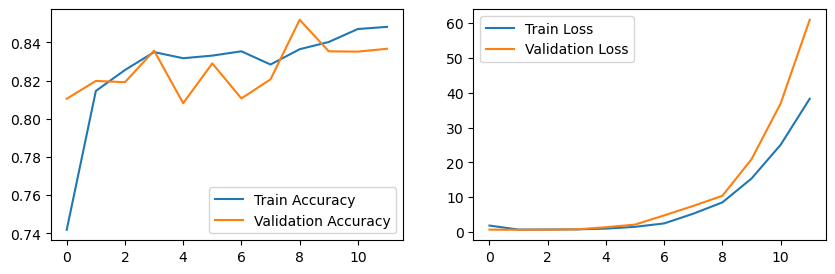

In [34]:
score = model3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_model_history_val(history_model3)

### model4

In [35]:
## Normalise values ~ [0,1]
x_trainN = x_train / 255.
x_testN  = x_test / 255.

In [36]:
## Model architecture ~ layers 

# Adding layers to extract features 

model4 = Sequential() # The sequential model is a linear stack of layers. Add layers by using the `add` method 

# Feature extration 

model4.add( Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=(28, 28, 1)) ) # # 2D Convolutional layer with 32 filters (output)
model4.add( MaxPooling2D(pool_size=(2,2)) ) 
model4.add( Conv2D(64, kernel_size=(3,3),activation='relu') ) # # 2D Convolutional layer with 64 filters (output)
#model4.add( MaxPooling2D(pool_size=(2,2)) ) 
#model4.add( Conv2D(128, kernel_size=(3,3),activation='relu') ) # # 2D Convolutional layer with 64 filters (output)
# Classification 
model4.add( Flatten())
model4.add( Dense(128, activation='relu'))
model4.add( Dense(N_CLASSES, activation='softmax'))

## Model compliation 
model4.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

In [37]:
history_model4 = model4.fit(x_trainN, y_train,
                  batch_size=BATCH,
                  epochs= EPOCHS,
                  verbose=1,
                  validation_split=0.2)

Epoch 1/12
375/375 [==============================] - 5s 14ms/step - loss: 0.5269 - accuracy: 0.8109 - val_loss: 0.3686 - val_accuracy: 0.8700
Epoch 2/12
375/375 [==============================] - 5s 14ms/step - loss: 0.3414 - accuracy: 0.8796 - val_loss: 0.3451 - val_accuracy: 0.8733
Epoch 3/12
375/375 [==============================] - 5s 13ms/step - loss: 0.2927 - accuracy: 0.8972 - val_loss: 0.3129 - val_accuracy: 0.8843
Epoch 4/12
375/375 [==============================] - 5s 13ms/step - loss: 0.2612 - accuracy: 0.9089 - val_loss: 0.2949 - val_accuracy: 0.8963
Epoch 5/12
375/375 [==============================] - 5s 13ms/step - loss: 0.2357 - accuracy: 0.9162 - val_loss: 0.3097 - val_accuracy: 0.8927
Epoch 6/12
375/375 [==============================] - 5s 13ms/step - loss: 0.2173 - accuracy: 0.9225 - val_loss: 0.3079 - val_accuracy: 0.8940
Epoch 7/12
375/375 [==============================] - 5s 13ms/step - loss: 0.2013 - accuracy: 0.9280 - val_loss: 0.3226 - val_accuracy: 0.8988

Test loss: 0.5242305994033813
Test accuracy: 0.8880000114440918


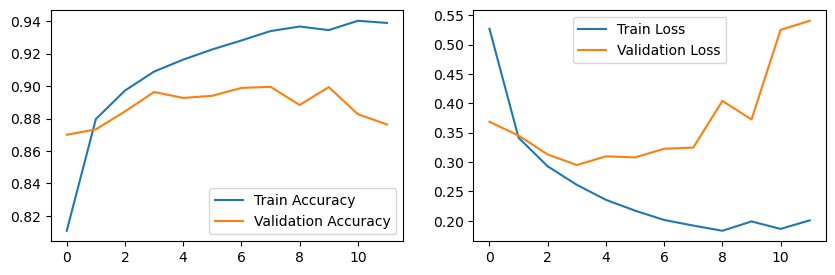

In [44]:
score = model4.evaluate(x_testN, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_model_history_val(history_model4)

### model5

In [41]:
## Model architecture ~ layers 

# Adding layers to extract features 

model5 = Sequential() # The sequential model is a linear stack of layers. Add layers by using the `add` method 

# Feature extration 
model5.add( Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=(28, 28, 1)) ) # # 2D Convolutional layer with 32 filters (output)
model5.add( MaxPooling2D(pool_size=(2,2)) ) 
model5.add( Dropout( 0.25))
model5.add( Conv2D(64, kernel_size=(3,3),activation='relu') ) # # 2D Convolutional layer with 64 filters (output)
model5.add( MaxPooling2D(pool_size=(2,2)) ) 
model5.add( Dropout( 0.25))
model5.add( Conv2D(128, kernel_size=(3,3),activation='relu') ) # # 2D Convolutional layer with 64 filters (output)
model5.add( Dropout( 0.40))
# Classification 
model5.add( Flatten())
model5.add( Dense(128, activation='relu'))
model5.add( Dropout( 0.30))
model5.add( Dense(N_CLASSES, activation='softmax'))

## Model compliation 
model5.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

history_model5 = model5.fit(x_trainN, y_train,
                  batch_size= BATCH,
                  epochs= EPOCHS+10,
                  verbose=1,
                  validation_split=0.2)

Epoch 1/22
375/375 [==============================] - 6s 15ms/step - loss: 0.8451 - accuracy: 0.6829 - val_loss: 0.5394 - val_accuracy: 0.8035
Epoch 2/22
375/375 [==============================] - 5s 15ms/step - loss: 0.5393 - accuracy: 0.8011 - val_loss: 0.4315 - val_accuracy: 0.8477
Epoch 3/22
375/375 [==============================] - 5s 15ms/step - loss: 0.4566 - accuracy: 0.8325 - val_loss: 0.3868 - val_accuracy: 0.8605
Epoch 4/22
375/375 [==============================] - 5s 14ms/step - loss: 0.4097 - accuracy: 0.8523 - val_loss: 0.3445 - val_accuracy: 0.8770
Epoch 5/22
375/375 [==============================] - 5s 15ms/step - loss: 0.3837 - accuracy: 0.8601 - val_loss: 0.3379 - val_accuracy: 0.8783
Epoch 6/22
375/375 [==============================] - 5s 14ms/step - loss: 0.3640 - accuracy: 0.8675 - val_loss: 0.3288 - val_accuracy: 0.8782
Epoch 7/22
375/375 [==============================] - 5s 15ms/step - loss: 0.3490 - accuracy: 0.8737 - val_loss: 0.3167 - val_accuracy: 0.8855

Test loss: 0.3122873902320862
Test accuracy: 0.8977000117301941


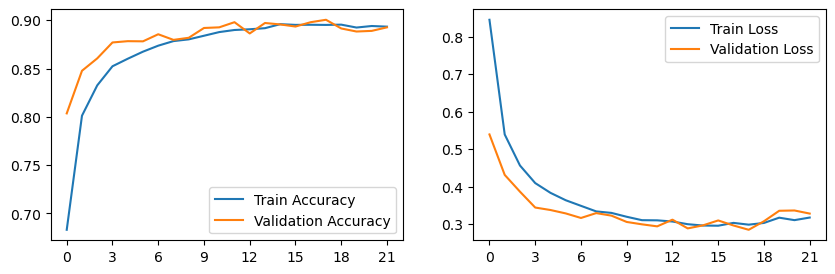

In [43]:
score = model5.evaluate(x_testN, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_model_history_val(history_model5)

## TensorBoard - Monitoring

In machine learning, to improve something you often need to be able to measure it. TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much [more](https://www.tensorflow.org/tensorboard/get_started).


In [117]:
# Monitoring 
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

When training with Keras's `Model.fit()`, adding the `tf.keras.callbacks.TensorBoard` callback ensures that logs are created and stored. Additionally, enable histogram computation every epoch with histogram_freq=1 (this is off by default)

Place the logs in a timestamped subdirectory to allow easy selection of different training runs.

In [120]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=10, 
          callbacks=[tensorboard_callback])

Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 39.8554 - accuracy: 0.8546
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 48.5526 - accuracy: 0.8497
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 50.3019 - accuracy: 0.8531
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 57.7599 - accuracy: 0.8518
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 70.3557 - accuracy: 0.8479
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 74.4036 - accuracy: 0.8517
Epoch 7/10
1875/1875 [==============================] - 18s 9ms/step - loss: 80.5719 - accuracy: 0.8507
Epoch 8/10
1875/1875 [==============================] - 18s 10ms/step - loss: 91.5114 - accuracy: 0.8509
Epoch 9/10
1875/1875 [==============================] - 18s 10ms/step - loss: 103.1026 - accuracy: 0.8478
Epoch 10/10
1875/1875 [==============================] 

Start TensorBoard through the command line or within a notebook experience. The two interfaces are generally the same. In notebooks, use the `%tensorboard` line magic. On the command line, run the same command without "`%`".

In [119]:
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.